### AutoEncoder - Based Decision

In [1]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import welch as pwelch
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from IPython.display import clear_output
%matplotlib widget

### Load the data

In [2]:
# Load AE-reconstructed data
with open('autoencoders/reconstruct_inf.pkl', 'rb') as f:
    info = pickle.load(f)

with open('autoencoders/reconstruct_inf2.pkl', 'rb') as f:
    info2 = pickle.load(f)

# Load metadata with ground truth (GT) labels
with open('autoencoders/metadata_SUB01_withGT.pkl', 'rb') as f:
    metadata = pickle.load(f)
    # Extract 'unknown' label data from metadata
    metadata_unknown = metadata.loc[metadata['labels'] == 'unknown']

# Extract relevant information from loaded data
waveforms_state_2d = info['waveforms_state_2d']  # All waveforms
reconstruct = info['reconstruct']  # Reconstructed samples
original_GT = info2['original_GT']  # Ground truth for original data
reconstruct_GT = info2['reconstruct_GT']  # Ground truth for reconstructed data
labels = info2['labels']  # List of labels for all data
states_GT = info2['states_GT']  # Ground truth states
bands = info2['bands']  # Frequency bands
power_GT = info2['power_GT']  # PSD power for CNN samples predicted with >90% confidence
centroids = info2['centroids']  # Centroid positions for each state
mid_points = info2['mid_points']  # Midpoints between centroids for transitions

clear_output()
print('Data and metadata loaded successfully.')


Data and metadata loaded successfully.


In [3]:
def find_closest_centroid(point, centroids, centroid_labels):
    # Calculate the Euclidean distances for all points at once
    distances = np.linalg.norm(centroids - point, axis=1)
    
    # get sorted indices
    sorted_indices_all = np.argsort(distances)
    
    # compute without intermediate centroids
    idx_centroids = [idx for idx, i in enumerate(centroid_labels) if i in ['slow_updown', 'asynch_MA', 'awake', 'slow_MA']]
    
    # Calculate the Euclidean distances for all points at once
    distances = np.linalg.norm(centroids[idx_centroids, :] - point, axis=1)
    
    # get sorted indices
    sorted_indices_no_interpoints = np.argsort(distances)
    
    # get state without intermediate centroids
    major_state = [centroid_labels[i] for i in idx_centroids][sorted_indices_no_interpoints[0]]
    
    if centroid_labels[sorted_indices_all[0]] in ['slow_updown', 'asynch_MA', 'awake', 'slow_MA', 'asynch_MA-slow_MA', 'slow_MA-asynch_MA']:
        return centroid_labels[sorted_indices_all[0]]
    elif centroid_labels[sorted_indices_all[0]] in ['slow_updown-awake', 'slow_updown-slow_MA', 'asynch_MA-awake', 'slow_updown-asynch_MA', 'asynch_MA-slow_updown', 'awake-slow_MA', 'awake-slow_updown', 'slow_MA-slow_updown', 'awake-asynch_MA', 'slow_MA-awake']:
        #option 1
        return major_state
    else:
        return 'half-state'

### Clusters

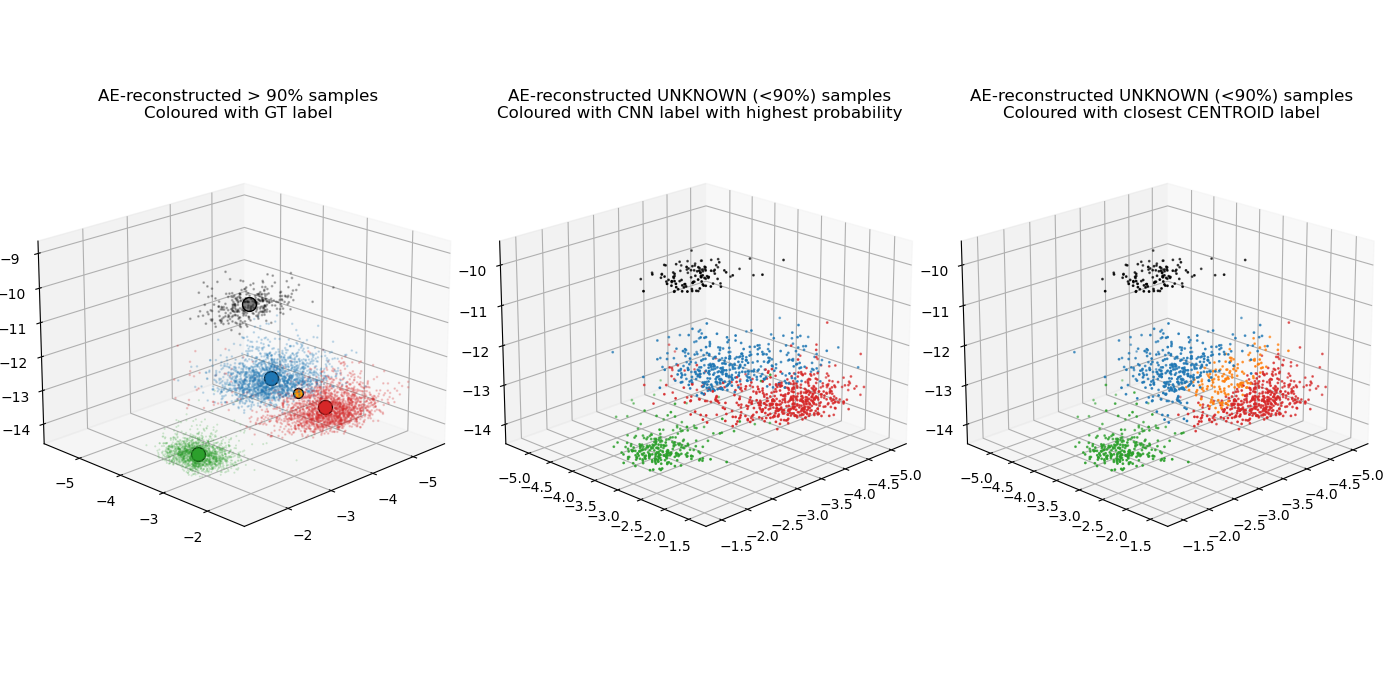

In [4]:
# Define color mapping for different states
colors = {
    'awake': 'k', 
    'slow_updown': 'tab:green', 
    'slow_MA': 'tab:red', 
    'asynch_MA': 'tab:blue', 
    'asynch_MA-slow_MA': 'tab:orange', 
    'slow_MA-asynch_MA': 'tab:orange'
}

# Initialize a 3D plot with 3 subplots
fig = plt.figure(figsize=(14, 7))
ax = [
    fig.add_subplot(131, projection='3d'), 
    fig.add_subplot(132, projection='3d'), 
    fig.add_subplot(133, projection='3d')
]

# Map GT labels to corresponding colors
colors_GT = [colors[label] for label in labels]

# Scatter plot for GT labels
for label in set(labels):
    ldx = np.where(np.array(labels) == label)[0]
    if label == 'slow_updown':
        ax[0].scatter(
            np.log(power_GT['reconstruct'][0, ldx][::3]), 
            np.log(power_GT['reconstruct'][1, ldx][::3]), 
            np.log(power_GT['reconstruct'][2, ldx][::3]), 
            c=colors[label], s=1, marker='.', alpha=0.2
        )
    elif label == 'awake':
        ax[0].scatter(
            np.log(power_GT['reconstruct'][0, ldx]), 
            np.log(power_GT['reconstruct'][1, ldx]), 
            np.log(power_GT['reconstruct'][2, ldx]), 
            c=colors[label], s=1, alpha=0.25
        )
    else:
        ax[0].scatter(
            np.log(power_GT['reconstruct'][0, ldx]), 
            np.log(power_GT['reconstruct'][1, ldx]), 
            np.log(power_GT['reconstruct'][2, ldx]), 
            c=colors[label], s=3, marker='.', alpha=0.2
        )

# Add centroids to the scatter plot
for label in set(labels):
    ax[0].scatter(
        centroids[label][0], centroids[label][1], centroids[label][2], 
        edgecolor='k', marker='o', s=100, 
        c=colors[label] if label != 'awake' else 'gray'
    )

# Add midpoints between centroids (for asynch_MA and slow_MA transitions)
unique_labels = list(set(labels))
for ldx0 in range(len(unique_labels)-1):
    for ldx1 in range(ldx0+1, len(unique_labels)):
        comb = f"{unique_labels[ldx0]}-{unique_labels[ldx1]}"
        if comb not in mid_points:
            comb = f"{unique_labels[ldx1]}-{unique_labels[ldx0]}"
        if comb in ['asynch_MA-slow_MA', 'slow_MA-asynch_MA']:
            ax[0].scatter(
                mid_points[comb][0], mid_points[comb][1], mid_points[comb][2], 
                marker='o', s=50, edgecolor='k', c='orange'
            )

# Title for the first subplot
ax[0].set_title('AE-reconstructed > 90% samples\nColoured with GT label')

# =========== UNKNOWN Scatter Plot with AE Label Colors ===========
# Define frequency bands
bands = [[0.1, 4], [4, 8], [100, 500]]

# Compute power spectral density for original and reconstructed data
fxx_original, pxx_original = pwelch(x=waveforms_state_2d['unknown'], fs=1000, nfft=1000, nperseg=500, axis=1)
fxx_reconstruct, pxx_reconstruct = pwelch(x=reconstruct, fs=1000, nfft=1000, nperseg=500, axis=1)

# Calculate power for the defined frequency bands
power = {'original': np.array([]), 'reconstruct': np.array([])}
for band in bands:
    band_power_original = np.mean(pxx_original[:, (fxx_original >= band[0]) & (fxx_original < band[1])], axis=1)
    power['original'] = np.vstack([power['original'], band_power_original]) if power['original'].size else band_power_original
    band_power_reconstruct = np.mean(pxx_reconstruct[:, (fxx_reconstruct >= band[0]) & (fxx_reconstruct < band[1])], axis=1)
    power['reconstruct'] = np.vstack([power['reconstruct'], band_power_reconstruct]) if power['reconstruct'].size else band_power_reconstruct

# Scatter plot for AE-reconstructed unknown samples
colors_unknownAE = [colors[label] for label in metadata_unknown['high_prob_state_label']]
ax[1].scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=colors_unknownAE, s=1)
ax[1].set_title('AE-reconstructed UNKNOWN (<90%) samples\nColoured with CNN label with highest probability')

# =========== UNKNOWN Scatter Plot with Centroid Classification Colors ===========
# Classify unknowns based on centroids
centroid_points = np.array([])
centroid_labels = []

# Collect midpoints and centroids into one array
for centroid_label, point in mid_points.items():
    centroid_points = np.vstack([centroid_points, np.array(point)]) if centroid_points.size else np.array(point)
    centroid_labels.append(centroid_label)
for centroid_label, point in centroids.items():
    centroid_points = np.vstack([centroid_points, np.array(point)])
    centroid_labels.append(centroid_label)

# Classify each unknown sample based on the closest centroid
labels_centroid_based = [find_closest_centroid(np.log(power['reconstruct'][:, i]), centroid_points, centroid_labels) for i in range(power['reconstruct'].shape[1])]
colors_unknowncentroid = [colors[label] for label in labels_centroid_based]

# Scatter plot for AE-reconstructed unknown samples (centroid classification)
ax[2].scatter(np.log(power['reconstruct'][0, :]), np.log(power['reconstruct'][1, :]), np.log(power['reconstruct'][2, :]), c=colors_unknowncentroid, s=1)
ax[2].set_title('AE-reconstructed UNKNOWN (<90%) samples\nColoured with closest CENTROID label')

# Set viewing angles for 3D plots
for axis in ax:
    axis.view_init(elev=20, azim=45)

# Adjust layout
plt.tight_layout()

### Compute power with respect to the confidence level used

In [5]:
df = pd.DataFrame(columns=['state', 'value', 'band', 'CL range'])
for thr in np.arange(0.5, 0.9, 0.1):
    tdx = np.where((metadata_unknown['prob']>thr)&(metadata_unknown['prob']<thr+0.1))[0]

    bands = [[0.1, 4], [4, 8], [100, 500]]
    fxx_original, pxx_original = pwelch(x=waveforms_state_2d['unknown'][tdx, :], fs=1000, nfft=1000, nperseg=500, axis=1)

    # build band power
    power = {'original': np.array([]), 'reconstruct': np.array([])}
    for bdx, band in enumerate(bands):
        band_power = np.mean(pxx_original[:, ((fxx_original>=band[0])&(fxx_original<band[1]))], axis=1)
        power['original'] = np.vstack([power['original'], band_power]) if power['original'].size else band_power

    # define arrays of labels for gt and predicted
    for label in set(labels):
        ldx = np.where(np.array(metadata_unknown['GT'][tdx])==label)[0]
        
        for i in range(3):
            df = pd.concat([df, pd.DataFrame({
                'state': [label] * len(ldx), 
                'value': np.log(power['original'][i, ldx]),
                'band': [str(bands[i])] * len(ldx), 
                'CL range' : [str(np.round(thr,2)) + '-' + str(np.round(thr+0.1,2))] * len(ldx),
            })], ignore_index=True)

Text(0, 0.5, 'Average Spectral Power')

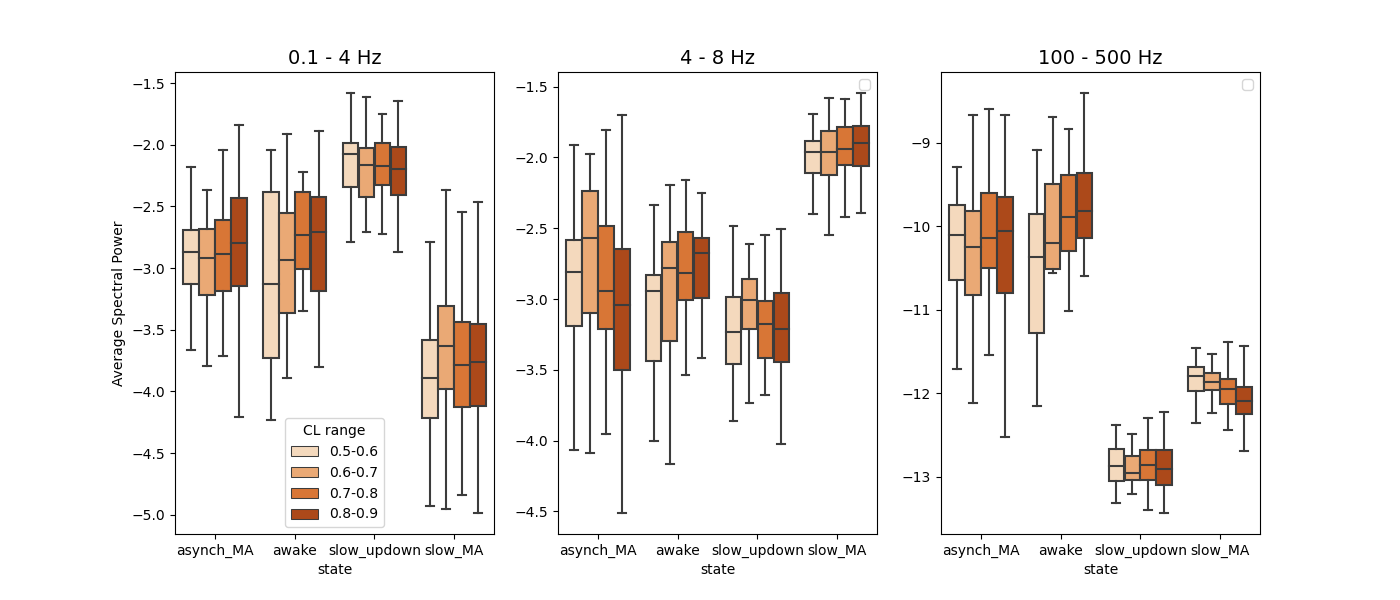

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 6))
for i in range(3):
    sns.boxplot(data=df.loc[df['band']== str(bands[i])], x='state', y='value', hue='CL range', ax=ax[i], palette='Oranges', showfliers=False)
    ax[i].set_title(bands[i])
    
ax[0].set_title('0.1 - 4 Hz', fontsize=14)
ax[1].set_title('4 - 8 Hz', fontsize=14)
ax[2].set_title('100 - 500 Hz', fontsize=14)
ax[1].legend([])
ax[2].legend([])
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_ylabel('Average Spectral Power')